In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import torch.optim as optim
import os
from torchvision import transforms
from dataset import get_handler, get_dataset
from dataset import get_dataset


/usr/local/home/sgchr/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-11 13:29:32.686816: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-11 13:29:32.731361: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-11 13:29:33.370253: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fi

Found 8812 images belonging to 2 classes.
Found 712 images belonging to 2 classes.


In [3]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [23]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16
        self.embDim = 128 * block.expansion
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 128, num_blocks[3], stride=2)
        self.linear = nn.Linear(2048 * block.expansion, num_classes, bias=False)
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        emb = out.view(out.size(0), -1)
        out = self.linear(emb)
        return out, emb
    def get_embedding_dim(self):
        return self.embDim

In [24]:
def ResNet18(num_classes=2):
    return ResNet(BasicBlock, [2,2,2,2], num_classes)

In [25]:
model = ResNet18(num_classes=2)

In [26]:
input_tensor = torch.randn(100, 3,128, 128)

In [27]:
output = model(input_tensor)

In [2]:
folder_path_benign = '/usr/local/home/sgchr/Documents/Cancer_classification/BreaKHis_v1/Cancer_train/benign'
image_files_benign = [os.path.join(folder_path_benign, filename) for filename in os.listdir(folder_path_benign)]

folder_path_mal = '/usr/local/home/sgchr/Documents/Cancer_classification/BreaKHis_v1/Cancer_train/malignant'
image_files_mal = [os.path.join(folder_path_mal, filename) for filename in os.listdir(folder_path_mal)]

from PIL import Image
X_tr = []
common_size = (128, 128)

for image_file in image_files_benign:
    img = cv2.imread(image_file)
    if img is not None:
        # Resize the image to the common size
        img = cv2.resize(img, common_size)
        # Image.fromarray((img/255).astype(np.uint8))
        X_tr.append(img)
    else:
        print(f"Error loading image: {image_file}")


for image_file in image_files_mal:
    img = cv2.imread(image_file)
    if img is not None:
        # Resize the image to the common size
        img = cv2.resize(img, common_size)
        X_tr.append(img)
    else:
        print(f"Error loading image: {image_file}")
X_tr = np.array(X_tr)
X_tr = torch.tensor(X_tr)

In [4]:
print(X_tr.dtype)

torch.uint8


In [24]:
# Calculate the number of samples in each part
total_samples = X_tr.shape[0]
samples_per_part = total_samples // 6

# Divide the tensor into three parts
part1 = X_tr[:samples_per_part]

In [2]:
X_tr, X_te, Y_tr, Y_te = get_dataset()


In [8]:
X_tr = torch.tensor(X_tr)

In [9]:
X_tr = np.array(X_tr)

In [5]:
class CancerModel(nn.Module):
    def __init__(self, num_classes = 2):
        super(CancerModel, self).__init__()

        self.embDim = 128
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.4)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.2)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(12544, 256)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu6 = nn.ReLU()
        self.fc3 = nn.Linear(128, 128)
        self.fc_multiclass = nn.Linear(128, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.maxpool1(self.relu1(self.conv1(x)))
        x = self.maxpool2(self.relu2(self.conv2(x)))
        x = self.maxpool3(self.relu3(self.conv3(x)))
        x = self.dropout1(x)
        x = self.maxpool4(self.relu4(self.conv4(x)))
        x = self.dropout2(x)
        x = self.flatten(x)
        x = self.relu5(self.fc1(x))
        x = self.relu6(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        multiclass_output = self.fc_multiclass(x)
        return  x   #return multiclass_ouput as well
    
    def get_embedding_dim(self):
        return self.embDim
cancer_model = CancerModel()

In [11]:
X_tr =np.transpose(X_tr, (0, 3, 1, 2))

In [12]:
class CustomDataset(Dataset):
    def __init__(self, inputs, labels, transform=None):
        self.inputs = inputs
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        input_data = self.inputs[index]
        label = self.labels[index]

        if self.transform:
            input_data = self.transform(input_data)

        return input_data, label
    
transforms_list = [transforms.RandomRotation(20),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomVerticalFlip(),
                        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                        # transforms.RandomResizedCrop(128),  # Assuming you want to resize images to 128x128
                        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=(0.2, 0.2)),
                        # transforms.Lambda(lambda x: custom_divide(x)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
transform = transforms.Compose(transforms_list)  # ImageNet mean and std
                    

# Create custom datasets
train_dataset = CustomDataset(inputs=X_tr, labels=Y_tr, transform=transform)
test_dataset = CustomDataset(inputs=X_te, labels=Y_te, transform=transform)

# Create DataLoader instances
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cancer_model.parameters(), lr=0.001)

# Step 3: Training loop
num_epochs = 5

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        # Step 4: Forward pass
        outputs = cancer_model(inputs)
        
        # Step 5: Compute loss
        loss = criterion(outputs, labels)
        
        # Step 6: Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        running_loss += loss.item()

    # Print statistics
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}, Accuracy: {correct_predictions / total_samples}')


TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

In [11]:
input_tensor = torch.randn(100, 3, 128, 128)

In [12]:
output_1 = cancer_model(input_tensor)

In [20]:
print(X_tr.dtype)


torch.uint8


In [21]:
for param in cancer_model.parameters():
    print(param.dtype)


torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32


In [22]:
X_tr = X_tr.to(dtype=torch.float32)


In [25]:
reshaped_Xtr = X_tr.permute(0, 3, 1, 2)

In [27]:
# a = cancer_model.forward(input_tensor)
output = cancer_model(reshaped_Xtr)

In [ ]:
out

In [32]:
handler = get_handler('BreaKHis')

In [33]:
type(handler)

type

In [34]:
args =  {'n_epoch': 20, 'transform':transforms.Compose([
                        # transforms.RandomRotation(20),
                        # transforms.RandomHorizontalFlip(),
                        # transforms.RandomVerticalFlip(),
                        # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                        # transforms.RandomResizedCrop(128),  # Assuming you want to resize images to 128x128
                        # transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=(0.2, 0.2)),
                        # # transforms.Lambda(lambda x: custom_divide(x)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet mean and std
                    ]),
                    'loader_tr_args':{'batch_size': 64, 'num_workers': 1},
                    'loader_te_args':{'batch_size': 100, 'num_workers': 1},
                    'optimizer_args':{'lr': 0.001, 'momentum': 0.5},
                    'transformTest' : transforms.Compose([
                        transforms.Resize(128),
                        transforms.CenterCrop(128),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
                    }

In [4]:
X_tr, X_te, Y_tr, Y_te = get_dataset()

In [6]:
print(X_te.dtype)

float64


In [5]:
print(X_tr.dtype)

float64


In [40]:
Y_tr = Y_tr[torch.randperm(len(Y_tr))]

In [89]:
sum(Y_tr)

tensor(4406)

In [48]:

one_fourth_index = len(X_tr) // 10

one_fourth_index_y = len(Y_tr) // 10

# Slice the data to get one fourth of the dataset
one_fourth_data = X_tr[:one_fourth_index]
one_fourth_data_y = Y_tr[:one_fourth_index_y]



In [49]:
sum(one_fourth_data_y)

tensor(466)

In [30]:

def predict(net,X, Y):
    if type(X) is np.ndarray:
        loader_te = DataLoader(handler(X, Y, transform=args['transformTest']),
                        shuffle=False, **args['loader_te_args'])
    else: 
        loader_te = DataLoader(handler(X.numpy(), Y, transform=args['transformTest']),
                        shuffle=False, **args['loader_te_args'])

    net.eval()
    P = torch.zeros(len(Y)).long()
    with torch.no_grad():
        for x, y, idxs in loader_te:
            x, y = Variable(x), Variable(y)
            out, e1 = net(x)
            pred = out.max(1)[1]
            P[idxs] = pred.data.cpu()
    return P

In [50]:
P = predict(cancer_model,one_fourth_data, one_fourth_data_y)

In [78]:
pred_zero = torch.any(P==0).item()

In [94]:
sum(P)

tensor(881)

In [36]:
def check_acc(net,X,Y):
    P = predict(net,X, Y)
    accur = 1.0 * (Y == P).sum().item() / len(Y)
    return accur

In [51]:
acc = check_acc(cancer_model,one_fourth_data, one_fourth_data_y)

In [3]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


In [4]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super(ResNet, self).__init__()
        self.in_planes = 16
        self.embDim = 128 * block.expansion
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 128, num_blocks[3], stride=2)
        self.linear = nn.Linear(128 * block.expansion, num_classes, bias=False)
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 2)
        emb = out.view(out.size(0), -1)
        out = self.linear(emb)
        return out, emb
    def get_embedding_dim(self):
        return self.embDim

In [5]:
def ResNet18(num_classes):
    return ResNet(BasicBlock, [2,2,2,2], num_classes)

In [6]:
model = ResNet18(num_classes=2)

In [7]:
input_tensor = torch.randn(100, 3, 128, 128)

In [8]:
output = model(input_tensor)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x8192 and 128x2)

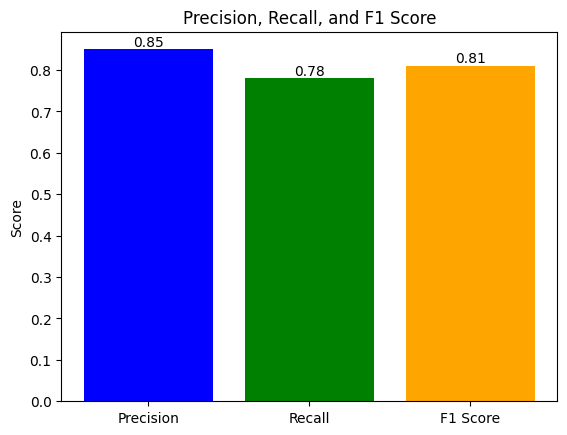

In [1]:
import matplotlib.pyplot as plt

# Example data
labels = ['Precision', 'Recall', 'F1 Score']
scores = [0.85, 0.78, 0.81]  # Replace with your actual scores

# Plotting
fig, ax = plt.subplots()
bars = ax.bar(labels, scores, color=['blue', 'green', 'orange'])

# Adding data labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Adding labels and title
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score')

# Show the plot
plt.show()

